## Часть 3.
### Формирование и отбор признаков


**Оглавление**
* Разделы:
    * [1. Формированиие признаков из предоставленных таблиц](#gostart)
    * [2. Построение базовой модели с учетом сформированных признаков](#gomodel)  
    * [3. Дополнительное формирование признаков](#goaddition)     
    * [4. Сохраннение(экспорт) датасетов](#goload)
    * [5. Вывод](#end)
        

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

# plt.style.use('fivethirtyeight')
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
# !pip install eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

from catboost import CatBoostClassifier

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
train = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/train.csv"))
test = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/test.csv"))
client_profile = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/client_profile.csv"))
payments = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/payments.csv"))
bki = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/bki.csv"))
applications_history = reduce_mem_usage(pd.read_csv(r"./competitive-data-analysis_coursework/applications_history.csv"))

Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.63 MB
Decreased by 75.0%
Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 0.79 MB
Decreased by 68.7%
Memory usage of dataframe is 45.78 MB
Memory usage after optimization is: 18.12 MB
Decreased by 60.4%
Memory usage of dataframe is 62.50 MB
Memory usage after optimization is: 29.30 MB
Decreased by 53.1%
Memory usage of dataframe is 122.60 MB
Memory usage after optimization is: 48.68 MB
Decreased by 60.3%
Memory usage of dataframe is 331.31 MB
Memory usage after optimization is: 114.69 MB
Decreased by 65.4%


#### Формированиие признаков из предоставленных таблиц <a class='anchor' id='gostart'>

In [4]:
# Смормируем признаки на остнове тех данных, которые есть в предоставленных таблицах.

In [5]:
cp_columns = [
 'APPLICATION_NUMBER',
 'GENDER',
 'TOTAL_SALARY',
 'AMOUNT_CREDIT',
 'AMOUNT_ANNUITY',
 'EDUCATION_LEVEL',
 'FAMILY_STATUS',
 'REGION_POPULATION',
 'AGE',
 'DAYS_ON_LAST_JOB',
 'OWN_CAR_AGE',
 'EXTERNAL_SCORING_RATING_1',
 'EXTERNAL_SCORING_RATING_2',
 'EXTERNAL_SCORING_RATING_3',
]

In [6]:
def get_str_fillna_hash(X):    
    for ii in X.select_dtypes(include=['object', 'category']).columns.tolist():
        X[ii] = X[ii].astype(str)

    for ii in X.select_dtypes(exclude=['object', 'category']).columns.tolist():
        X[ii] = X[ii].fillna(0)
    X = X.replace([-np.inf, np.inf], [0, 0])

    hash_space = 0.1
    for item_column in X.select_dtypes(include=['object', 'category']).columns.tolist():
        for itm in X[item_column].value_counts().index.tolist():
            X.loc[X[item_column] == itm, item_column] = (hash(itm) % hash_space)

        X[item_column] = X[item_column].astype('float')
    return X  

In [7]:
client_profile = get_str_fillna_hash(client_profile[cp_columns])
payments = get_str_fillna_hash(payments)
bki = get_str_fillna_hash(bki)
applications_history = get_str_fillna_hash(applications_history)

In [4]:
all_train = pd.merge(train, client_profile[cp_columns], on='APPLICATION_NUMBER', how='left')

In [9]:
all_train['DAYS_ON_LAST_JOB'].replace(365243, 0, inplace= True)

In [10]:
my_train2 = pd.merge(train, payments, on='APPLICATION_NUMBER', how='left')

In [11]:
my_train2.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,49796018.0,1.0,4.0,2830.0,2830.0,3289.63501,3289.63501
1,123687442,0,Cash,49796018.0,1.0,7.0,2740.0,2740.0,3289.63501,3289.63501


In [12]:
my_train2['D_INSTALMENT/D_ENTRY_PAYMENT'] = my_train2['DAYS_INSTALMENT'] - my_train2['DAYS_ENTRY_PAYMENT']

In [13]:
prev_numb = my_train2.groupby(['APPLICATION_NUMBER'], as_index=False).agg({'PREV_APPLICATION_NUMBER': 'count'})
prev_numb.head(2)

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER
0,123423341,2
1,123423345,2


In [14]:
table1 = my_train2.groupby(['APPLICATION_NUMBER'], as_index=False).agg({
    'AMT_INSTALMENT': 'sum',
    'AMT_PAYMENT': 'sum',
    'D_INSTALMENT/D_ENTRY_PAYMENT': 'sum'})
table1.head(2)

,APPLICATION_NUMBER,AMT_INSTALMENT,AMT_PAYMENT,D_INSTALMENT/D_ENTRY_PAYMENT
0,123423341,18503.550781,18503.550781,-34.0
1,123423345,31510.439453,31510.439453,-48.0


In [15]:
all_train = pd.merge(all_train, table1, on='APPLICATION_NUMBER', how='left')
all_train = pd.merge(all_train, prev_numb, on='APPLICATION_NUMBER', how='left')
all_train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_INSTALMENT,AMT_PAYMENT,D_INSTALMENT/D_ENTRY_PAYMENT,PREV_APPLICATION_NUMBER
0,123687442,0,Cash,0.065471,157500.0,855000.0,25128.0,0.060722,0.078874,0.019101,15728.0,1719.0,11.0,0.700784,0.645914,0.71657,25103.699219,15841.485352,-24.0,4
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11349.900391,11349.900391,-7.0,1


In [16]:
for ii in ['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3']:
    all_train[ii].fillna(0, inplace=True)

all_train['sum_EXTERNAL_SR'] = all_train['EXTERNAL_SCORING_RATING_1'] + all_train['EXTERNAL_SCORING_RATING_2'] + all_train['EXTERNAL_SCORING_RATING_3']
all_train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_INSTALMENT,AMT_PAYMENT,D_INSTALMENT/D_ENTRY_PAYMENT,PREV_APPLICATION_NUMBER,sum_EXTERNAL_SR
0,123687442,0,Cash,0.065471,157500.0,855000.0,25128.0,0.060722,0.078874,0.019101,...,1719.0,11.0,0.700784,0.645914,0.71657,25103.699219,15841.485352,-24.0,4,2.063268
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.00000,11349.900391,11349.900391,-7.0,1,0.000000


In [17]:
# Создадим несколько признаков
all_train['diff_INSTALMENT_PAYMENT'] = all_train['AMT_INSTALMENT'] - all_train['AMT_PAYMENT']

all_train['AMOUNT_ANNUITY/TOTAL_SALARY'] = all_train['AMOUNT_ANNUITY'] / all_train['TOTAL_SALARY']

all_train['AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train['AMOUNT_CREDIT'] / all_train['AMOUNT_ANNUITY']

In [ ]:
# plt.figure(figsize = (22,10))
# sns.scatterplot(all_train[('D_INSTALMENT/D_ENTRY_PAYMENT', 'sum')], all_train[('diff_INSTALMENT_PAYMENT')], size=0.9, alpha=0.9, hue=all_train['TARGET'])
# # plt.ylim(-1000, 1000)

In [ ]:
# Теперь 2 датасет

In [18]:
my_train3 = pd.merge(train, bki, on='APPLICATION_NUMBER', how='left')

In [19]:
my_train3.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123687442,0,Cash,5640206.0,0.030593,0.042734,2562.0,0.0,2197.0,2162.0,4714.424805,0.0,56362.50000,0.0,0.0,0.0,0.093552,2162.0,0.0
1,123597908,1,Cash,5970760.0,0.030593,0.042734,1809.0,0.0,1475.0,1503.0,0.000000,0.0,56376.00000,0.0,0.0,0.0,0.093552,731.0,0.0
2,123597908,1,Cash,5923029.0,0.030593,0.042734,434.0,0.0,130.0,130.0,0.000000,0.0,137910.59375,0.0,0.0,0.0,0.093552,126.0,0.0
3,123597908,1,Cash,5952522.0,0.081113,0.042734,141.0,0.0,225.0,0.0,0.000000,0.0,264010.50000,181561.5,0.0,0.0,0.093552,10.0,0.0
4,123597908,1,Cash,5912683.0,0.030593,0.042734,1213.0,0.0,86.0,98.0,0.000000,0.0,294615.00000,0.0,0.0,0.0,0.093552,83.0,0.0


In [20]:
table2 = my_train3.groupby(['APPLICATION_NUMBER'], as_index=False).agg({
    'BUREAU_ID': 'count'})
table2.head()

,APPLICATION_NUMBER,BUREAU_ID
0,123423341,5
1,123423345,0
2,123423349,0
3,123423351,0
4,123423352,2


In [21]:
all_train = pd.merge(all_train, table2, on='APPLICATION_NUMBER', how='left')

In [22]:
# Последний датасет

In [23]:
my_train4 = pd.merge(train, applications_history, on='APPLICATION_NUMBER', how='left')

In [24]:
my_train4.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE_x,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_y,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123687442,0,Cash,49915814.0,0.002115,6510.015137,71668.796875,64500.300781,7168.500000,71668.796875,...,0.019389,20.0,12.0,0.026987,365243.0,143.0,187.0,365243.0,365243.0,0.0
1,123687442,0,Cash,49713743.0,0.002115,9262.214844,72634.140625,70758.000000,7267.140137,72634.140625,...,0.019389,90.0,10.0,0.071734,365243.0,2671.0,2401.0,2401.0,2368.0,1.0
2,123687442,0,Cash,49704707.0,0.002115,7339.185059,62058.601562,67518.000000,3.600000,62058.601562,...,0.019389,150.0,10.0,0.071384,365243.0,690.0,420.0,420.0,415.0,0.0
3,123597908,1,Cash,48716994.0,0.015808,38667.601562,495000.000000,672948.000000,0.000000,495000.000000,...,0.017147,-1.0,36.0,0.071734,0.0,0.0,0.0,0.0,0.0,0.0
4,123597908,1,Cash,49672074.0,0.002115,11349.900391,75510.000000,82156.500000,0.000000,75510.000000,...,0.019389,12.0,10.0,0.071734,365243.0,690.0,420.0,420.0,413.0,0.0


In [25]:
table3 = my_train4.groupby(['APPLICATION_NUMBER'], as_index=False).agg({
    'DAYS_DECISION': 'max',
    'SELLERPLACE_AREA': 'count',
    'CNT_PAYMENT': 'sum'})
table3.head()

,APPLICATION_NUMBER,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT
0,123423341,606.0,1,24.0
1,123423345,617.0,9,138.0
2,123423349,1070.0,1,10.0
3,123423351,1673.0,4,54.0
4,123423352,1999.0,4,52.0


In [26]:
all_train = pd.merge(all_train, table3, on='APPLICATION_NUMBER', how='left')
all_train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,D_INSTALMENT/D_ENTRY_PAYMENT,PREV_APPLICATION_NUMBER,sum_EXTERNAL_SR,diff_INSTALMENT_PAYMENT,AMOUNT_ANNUITY/TOTAL_SALARY,AMOUNT_CREDIT/AMOUNT_ANNUITY,BUREAU_ID,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT
0,123687442,0,Cash,0.065471,157500.0,855000.0,25128.0,0.060722,0.078874,0.019101,...,-24.0,4,2.063268,9262.213867,0.159543,34.025787,1,2702.0,3,32.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-7.0,1,0.000000,0.000000,NaN,NaN,9,903.0,4,106.0
2,123526683,0,Cash,0.083986,135000.0,1006920.0,42660.0,0.053462,0.078874,0.026392,...,-1.0,4,0.950018,0.000000,0.316000,23.603376,9,2829.0,6,72.0
3,123710391,1,Cash,0.065471,180000.0,518562.0,22972.5,0.060722,0.078874,0.031329,...,-11.0,1,0.341745,0.000000,0.127625,22.573164,1,1904.0,2,28.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-60.0,4,0.000000,0.000000,NaN,NaN,3,1522.0,9,246.0


In [27]:
all_train = get_str_fillna_hash(all_train)
all_train.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,D_INSTALMENT/D_ENTRY_PAYMENT,PREV_APPLICATION_NUMBER,sum_EXTERNAL_SR,diff_INSTALMENT_PAYMENT,AMOUNT_ANNUITY/TOTAL_SALARY,AMOUNT_CREDIT/AMOUNT_ANNUITY,BUREAU_ID,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT
0,123687442,0,0.015808,0.065471,157500.0,855000.0,25128.0,0.060722,0.078874,0.019101,...,-24.0,4,2.063268,9262.213867,0.159543,34.025787,1,2702.0,3,32.0
1,123597908,1,0.015808,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,-7.0,1,0.000000,0.000000,0.000000,0.000000,9,903.0,4,106.0


#### Построение базовой модели с учетом сформированных признаков <a class='anchor' id='gomodel'>

In [51]:
cat_features_idx0 = np.where(all_train3.drop('TARGET', axis=1).dtypes == 'object')[0].tolist()

X0 = all_train3.drop('TARGET', axis=1)
y0 = all_train3['TARGET']

X_train0, X_part0, y_train0, y_part0 = train_test_split(X0, y0, train_size=0.6, random_state=99, stratify=y0)

X_valid0, X_test0, y_valid0, y_test0 = train_test_split(X_part0, y_part0, train_size=0.5, random_state=99, stratify=y_part0)

In [52]:
params_ctb = {
#     'learning_rate': 0.005,
    "n_estimators": 1500,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 3,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 150,
    "thread_count": 6,
    "random_seed": 99
}


In [53]:
model_ctb0 = CatBoostClassifier(**params_ctb)
model_ctb0.fit(X_train0, y_train0, eval_set=[(X_train0, y_train0), (X_valid0, y_valid0)], cat_features=cat_features_idx0)

0:	test: 0.6344696	test1: 0.6320115	best: 0.6320115 (0)	total: 58.6ms	remaining: 1m 27s
50:	test: 0.6948231	test1: 0.6875920	best: 0.6875920 (50)	total: 2.77s	remaining: 1m 18s
100:	test: 0.7070400	test1: 0.6987326	best: 0.6988402 (97)	total: 5.45s	remaining: 1m 15s
150:	test: 0.7188859	test1: 0.7055851	best: 0.7056099 (148)	total: 8.03s	remaining: 1m 11s
200:	test: 0.7371949	test1: 0.7094104	best: 0.7094104 (200)	total: 10.5s	remaining: 1m 7s
250:	test: 0.7418153	test1: 0.7114955	best: 0.7114955 (250)	total: 12.9s	remaining: 1m 4s
300:	test: 0.7442908	test1: 0.7127956	best: 0.7127956 (300)	total: 15.5s	remaining: 1m 1s
350:	test: 0.7466012	test1: 0.7141329	best: 0.7141329 (350)	total: 18.1s	remaining: 59.1s
400:	test: 0.7490955	test1: 0.7157622	best: 0.7157622 (400)	total: 20.6s	remaining: 56.4s
450:	test: 0.7504999	test1: 0.7160328	best: 0.7161196 (441)	total: 23s	remaining: 53.5s
500:	test: 0.7515775	test1: 0.7158554	best: 0.7161659 (461)	total: 25.4s	remaining: 50.6s
550:	test: 0.7

Text(0.5, 1.0, 'What are the top important features to start with?')

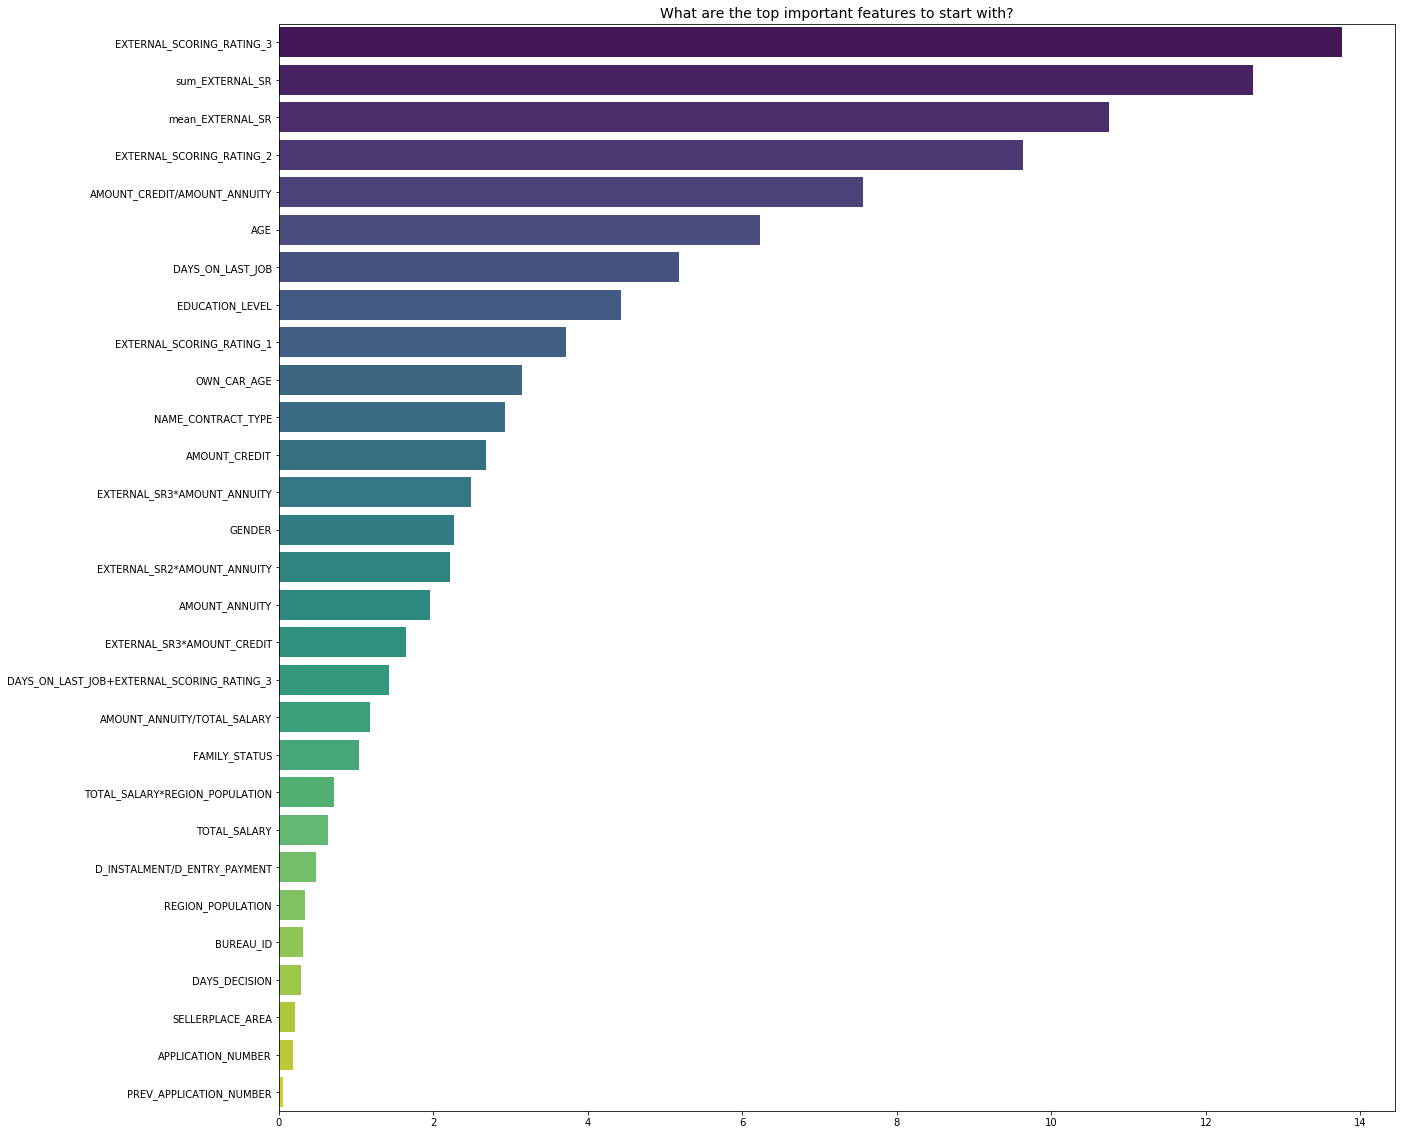

In [54]:
n_top = 50
importances = model_ctb0.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = all_train3.drop('TARGET', axis=1).columns

plt.figure(figsize=(20, 20))
sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis", orient='h')
plt.title("What are the top important features to start with?", size=14)

In [33]:
def calculate_feature_separating_ability(
    features: pd.DataFrame, target: pd.Series, fill_value: float = -9999) -> pd.DataFrame:
    """
    Оценка разделяющей способности признаков с помощью метрики GINI.

    Parameters
    ----------
    features: pandas.core.frame.DataFrame
        Матрица признаков.

    target: pandas.core.frame.Series
        Вектор целевой переменной.

    fill_value: float, optional, default = -9999
        Значение для заполнения пропусков в значении признаков.
        Опциональный параметр, по умолчанию, равен -9999;

    Returns
    -------
    scores: pandas.core.frame.DataFrame
        Матрица важности признаков.

    """
    scores = {}
    for feature in features:
        score = roc_auc_score(
            target, features[feature].fillna(fill_value)
        )
        scores[feature] = 2*score - 1

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [34]:
numerical = all_train.drop('TARGET', axis=1).select_dtypes(exclude=["object"])
# numerical = numerical.merge(train["APPLICATION_NUMBER"], how="right", on="APPLICATION_NUMBER")

scores = calculate_feature_separating_ability(
    numerical, all_train["TARGET"]
)
scores

EDUCATION_LEVEL                 0.059283
AMOUNT_ANNUITY/TOTAL_SALARY     0.022614
BUREAU_ID                       0.011191
FAMILY_STATUS                   0.005514
DAYS_DECISION                   0.005302
SELLERPLACE_AREA                0.003135
D_INSTALMENT/D_ENTRY_PAYMENT    0.002592
CNT_PAYMENT                    -0.000316
diff_INSTALMENT_PAYMENT        -0.001667
PREV_APPLICATION_NUMBER        -0.001829
AMOUNT_ANNUITY                 -0.002536
APPLICATION_NUMBER             -0.004743
AMT_PAYMENT                    -0.005533
AMT_INSTALMENT                 -0.005599
OWN_CAR_AGE                    -0.017698
DAYS_ON_LAST_JOB               -0.024890
TOTAL_SALARY                   -0.026845
AMOUNT_CREDIT                  -0.028179
NAME_CONTRACT_TYPE             -0.033864
REGION_POPULATION              -0.046066
AMOUNT_CREDIT/AMOUNT_ANNUITY   -0.047103
GENDER                         -0.062466
EXTERNAL_SCORING_RATING_1      -0.065214
AGE                            -0.118423
EXTERNAL_SCORING

In [35]:
estimator = PermutationImportance(
    model_ctb0, scoring="roc_auc", random_state=99
)
importance = estimator.fit(X_test0, y_test0)

In [36]:
show_weights(importance, feature_names=X_test0.columns.tolist(), top=X_test0.shape[1])

Weight,Feature
0.0312 ± 0.0037,EXTERNAL_SCORING_RATING_3
0.0286 ± 0.0056,EXTERNAL_SCORING_RATING_2
0.0249 ± 0.0021,sum_EXTERNAL_SR
0.0120 ± 0.0046,AMOUNT_CREDIT/AMOUNT_ANNUITY
0.0091 ± 0.0030,AGE
0.0086 ± 0.0030,EDUCATION_LEVEL
0.0062 ± 0.0043,NAME_CONTRACT_TYPE
0.0061 ± 0.0030,DAYS_ON_LAST_JOB
0.0061 ± 0.0012,EXTERNAL_SCORING_RATING_1
0.0052 ± 0.0022,GENDER


In [37]:
importance = permutation_importance(
    model_ctb0, X_test0, y_test0, scoring="roc_auc", n_jobs=6, random_state=99
)

In [39]:
importance_scores = pd.DataFrame({
    "features": X_test0.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=5]
decrease_scores = decrease_scores.reset_index(drop=True)
decrease_scores

,features,importance-mean,importance-std
0,EXTERNAL_SCORING_RATING_2,0.031506,0.001070
1,EXTERNAL_SCORING_RATING_3,0.031114,0.002789
2,sum_EXTERNAL_SR,0.026688,0.002055
3,AMOUNT_CREDIT/AMOUNT_ANNUITY,0.012053,0.002044
4,AGE,0.009681,0.002108
5,EDUCATION_LEVEL,0.008974,0.001018
6,DAYS_ON_LAST_JOB,0.006975,0.001574
7,GENDER,0.006149,0.001295
8,EXTERNAL_SCORING_RATING_1,0.005600,0.000994
9,NAME_CONTRACT_TYPE,0.005243,0.000785


In [40]:
droplist = [
#             'BUREAU_ID',
#             'D_INSTALMENT/D_ENTRY_PAYMENT',
            'CNT_PAYMENT',
#             'TOTAL_SALARY',
#             'REGION_POPULATION',
            'AMT_INSTALMENT',
            'AMT_PAYMENT',
#             'PREV_APPLICATION_NUMBER',
            'diff_INSTALMENT_PAYMENT',
#             'SELLERPLACE_AREA',
#             'DAYS_DECISION',
]

#### Дополнительное формирование признаков <a class='anchor' id='goaddition'>

In [ ]:
# Эксперимент с конкатенацией признаков

In [41]:
all_train2 = all_train.drop(droplist, axis=1).copy()
list1 = [
#     'APPLICATION_NUMBER',
#  'NAME_CONTRACT_TYPE',
#  'GENDER',
#  'AMOUNT_CREDIT',
#  'AMOUNT_ANNUITY',
#  'EDUCATION_LEVEL',
#  'FAMILY_STATUS',
#  'AGE',
#  'DAYS_ON_LAST_JOB',
#  'OWN_CAR_AGE',
#  'EXTERNAL_SCORING_RATING_1',
#  'EXTERNAL_SCORING_RATING_2',
#  'EXTERNAL_SCORING_RATING_3',
#  'sum_EXTERNAL_SR',
#  'AMOUNT_ANNUITY/TOTAL_SALARY',
#  'AMOUNT_CREDIT/AMOUNT_ANNUITY',
#  'DAYS_DECISION',
 'SELLERPLACE_AREA',
]
list2 = [
    'APPLICATION_NUMBER',
 'NAME_CONTRACT_TYPE',
 'GENDER',
 'AMOUNT_CREDIT',
 'AMOUNT_ANNUITY',
 'EDUCATION_LEVEL',
 'FAMILY_STATUS',
 'AGE',
 'DAYS_ON_LAST_JOB',
 'OWN_CAR_AGE',
 'EXTERNAL_SCORING_RATING_1',
 'EXTERNAL_SCORING_RATING_2',
 'EXTERNAL_SCORING_RATING_3',
 'sum_EXTERNAL_SR',
 'AMOUNT_ANNUITY/TOTAL_SALARY',
 'AMOUNT_CREDIT/AMOUNT_ANNUITY',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
        ]

In [ ]:
# Конкатенация признаков
for feature in tqdm(list1):
    for feature_rev in list2:
        all_train2[f'{feature}+{feature_rev}'] = all_train2[feature].astype('str') + "|" +  all_train2[feature_rev].astype('str')


In [ ]:
# В ходе длительных экспериментов с канкатенацией была выявлена лучшая канкатенация признаков

# all_train2['NAME_CONTRACT_TYPE+EXTERNAL_SCORING_RATING_3'] = all_train2['NAME_CONTRACT_TYPE'].astype('str') + all_train2['EXTERNAL_SCORING_RATING_3'].astype('str')
# all_train2['NAME_CONTRACT_TYPE+AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train2['NAME_CONTRACT_TYPE'].astype('str') + all_train2['AMOUNT_CREDIT/AMOUNT_ANNUITY'].astype('str')
# all_train2['NAME_CONTRACT_TYPE+EDUCATION_LEVEL'] = all_train2['NAME_CONTRACT_TYPE'].astype('str') + all_train2['EDUCATION_LEVEL'].astype('str')
# all_train2['NAME_CONTRACT_TYPE+GENDER'] = all_train2['NAME_CONTRACT_TYPE'].astype('str') + all_train2['GENDER'].astype('str')
# all_train2['NAME_CONTRACT_TYPE+AMOUNT_CREDIT'] = all_train2['NAME_CONTRACT_TYPE'].astype('str') + all_train2['AMOUNT_CREDIT'].astype('str')
# all_train2['NAME_CONTRACT_TYPE+OWN_CAR_AGE'] = all_train2['NAME_CONTRACT_TYPE'].astype('str') + all_train2['OWN_CAR_AGE'].astype('str')

# all_train2['GENDER+EXTERNAL_SCORING_RATING_3'] = all_train2['GENDER'].astype('str') + all_train2['EXTERNAL_SCORING_RATING_3'].astype('str')
# all_train2['GENDER+AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train2['GENDER'].astype('str') + all_train2['AMOUNT_CREDIT/AMOUNT_ANNUITY'].astype('str')
# all_train2['GENDER+AMOUNT_CREDIT'] = all_train2['GENDER'].astype('str') + all_train2['AMOUNT_CREDIT'].astype('str')

# all_train2['AMOUNT_CREDIT+AMOUNT_ANNUITY'] = all_train2['AMOUNT_CREDIT'].astype('str') + all_train2['AMOUNT_ANNUITY'].astype('str')

#0.7161916
# all_train2['AMOUNT_ANNUITY+AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train2['AMOUNT_ANNUITY'].astype('str') + all_train2['AMOUNT_CREDIT/AMOUNT_ANNUITY'].astype('str')

# all_train2['EDUCATION_LEVEL+EXTERNAL_SCORING_RATING_3'] = all_train2['EDUCATION_LEVEL'].astype('str') + all_train2['EXTERNAL_SCORING_RATING_3'].astype('str')
# all_train2['EDUCATION_LEVEL+AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train2['EDUCATION_LEVEL'].astype('str') + all_train2['AMOUNT_CREDIT/AMOUNT_ANNUITY'].astype('str')

#0.7166281463
# all_train2['DAYS_ON_LAST_JOB+EXTERNAL_SCORING_RATING_3'] = all_train2['DAYS_ON_LAST_JOB'].astype('str') + all_train2['EXTERNAL_SCORING_RATING_3'].astype('str')

# all_train2['OWN_CAR_AGE+AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train2['OWN_CAR_AGE'].astype('str') + all_train2['AMOUNT_CREDIT/AMOUNT_ANNUITY'].astype('str')

# all_train2['EXTERNAL_SCORING_RATING_1+AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train2['EXTERNAL_SCORING_RATING_1'].astype('str') + all_train2['AMOUNT_CREDIT/AMOUNT_ANNUITY'].astype('str')
           
# all_train2['EXTERNAL_SCORING_RATING_1+EXTERNAL_SCORING_RATING_1'] = all_train2['EXTERNAL_SCORING_RATING_1'].astype('str') + all_train2['EXTERNAL_SCORING_RATING_1'].astype('str')

# all_train2['SELLERPLACE_AREA+EXTERNAL_SCORING_RATING_3'] = all_train2['SELLERPLACE_AREA'].astype('str') + all_train2['EXTERNAL_SCORING_RATING_3'].astype('str')


In [ ]:
# Однако в ходе экспериментов с канкатенацией не нашлось парных признаков, которые бы значительно улучшали модель,
#   базовое качество на валидации 0,715 незначительно улучшено (вариации +- 0.001).

In [42]:
all_train3 = all_train.drop(droplist, axis=1).copy()

In [43]:
all_train3.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,D_INSTALMENT/D_ENTRY_PAYMENT,PREV_APPLICATION_NUMBER,sum_EXTERNAL_SR,AMOUNT_ANNUITY/TOTAL_SALARY,AMOUNT_CREDIT/AMOUNT_ANNUITY,BUREAU_ID,DAYS_DECISION,SELLERPLACE_AREA
0,123687442,0,0.015808,0.065471,157500.0,855000.0,25128.0,0.060722,0.078874,0.019101,...,0.645914,0.716570,-24.0,4,2.063268,0.159543,34.025787,1,2702.0,3
1,123597908,1,0.015808,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,-7.0,1,0.000000,0.000000,0.000000,9,903.0,4
2,123526683,0,0.015808,0.083986,135000.0,1006920.0,42660.0,0.053462,0.078874,0.026392,...,0.682149,0.267869,-1.0,4,0.950018,0.316000,23.603376,9,2829.0,6
3,123710391,1,0.015808,0.065471,180000.0,518562.0,22972.5,0.060722,0.078874,0.031329,...,0.171299,0.170446,-11.0,1,0.341745,0.127625,22.573164,1,1904.0,2
4,123590329,1,0.015808,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,-60.0,4,0.000000,0.000000,0.000000,3,1522.0,9


In [ ]:
# риск невозврата от образования

In [44]:
all_train3.groupby(['EDUCATION_LEVEL', 'TARGET'], as_index=False)['APPLICATION_NUMBER'].count()

,EDUCATION_LEVEL,TARGET,APPLICATION_NUMBER
0,0.000000,0,18865
1,0.000000,1,1689
2,0.053462,0,20671
3,0.053462,1,1131
4,0.060722,0,57816
5,0.060722,1,5690
6,0.072289,0,37
7,0.077112,0,2810
8,0.077112,1,271
9,0.083675,0,997


In [ ]:
# Риск невозврата у людей с образованием academic degree(hash 0.070314) нулевой! Однако это не дает прирост качества.(проверено)

In [ ]:
# Сформируем еще ряд признаков на основе бизнес-логики. (каждый раз использовалась вышеописанная модель катбуста)

In [ ]:
# all_train3['AMOUNT_ANNUITY/AGE'] = all_train3['AMOUNT_ANNUITY'] / all_train3['AGE']

In [ ]:
# all_train3['AMOUNT_CREDIT/AGE'] = all_train3['AMOUNT_CREDIT'] / all_train3['AGE']

In [ ]:
# all_train3['TOTAL_SALARY/DAYS_ON_LAST_JOB'] = all_train3['TOTAL_SALARY'] / all_train3['DAYS_ON_LAST_JOB']

In [ ]:
# all_train3['AMOUNT_CREDIT/DAYS_ON_LAST_JOB'] = all_train3['AMOUNT_CREDIT'] / all_train3['DAYS_ON_LAST_JOB']

In [ ]:
# all_train3['AMOUNT_ANNUITY/DAYS_ON_LAST_JOB'] = all_train3['AMOUNT_ANNUITY'] / all_train3['DAYS_ON_LAST_JOB']

In [45]:
# Чуть больше прибавляет
all_train3['TOTAL_SALARY*REGION_POPULATION'] = all_train3['TOTAL_SALARY'] * all_train3['REGION_POPULATION']

In [46]:
all_train3['mean_EXTERNAL_SR'] = (all_train3['EXTERNAL_SCORING_RATING_1'] + all_train3['EXTERNAL_SCORING_RATING_2'] + all_train3['EXTERNAL_SCORING_RATING_3'] ) / 3

In [ ]:
# all_train3['EXTERNAL_SR1*AMOUNT_CREDIT'] = all_train3['EXTERNAL_SCORING_RATING_1'] * all_train3['AMOUNT_CREDIT']

In [ ]:
# all_train3['EXTERNAL_SR2*AMOUNT_CREDIT'] = all_train3['EXTERNAL_SCORING_RATING_2'] * all_train3['AMOUNT_CREDIT']

In [47]:
# Чуть больше прибавляет
all_train3['EXTERNAL_SR3*AMOUNT_CREDIT'] = all_train3['EXTERNAL_SCORING_RATING_3'] * all_train3['AMOUNT_CREDIT']

In [ ]:
# all_train3['EXTERNAL_SR1*AMOUNT_ANNUITY'] = all_train3['EXTERNAL_SCORING_RATING_1'] * all_train3['AMOUNT_ANNUITY']

In [48]:
# Чуть больше прибавляет
all_train3['EXTERNAL_SR2*AMOUNT_ANNUITY'] = all_train3['EXTERNAL_SCORING_RATING_2'] * all_train3['AMOUNT_ANNUITY']

In [49]:
# Чуть больше прибавляет
all_train3['EXTERNAL_SR3*AMOUNT_ANNUITY'] = all_train3['EXTERNAL_SCORING_RATING_3'] * all_train3['AMOUNT_ANNUITY']

In [50]:
# all_train3['DAYS_ON_LAST_JOB+EXTERNAL_SCORING_RATING_3'] = all_train3['DAYS_ON_LAST_JOB'].astype('str') + all_train3['EXTERNAL_SCORING_RATING_3'].astype('str')

In [ ]:
# В ходе отбора были выявлены признаки, которые улучшают качество базовой модели при фиксированных параметрах модели.

#### Сохраннение(экспорт) датасетов <a class='anchor' id='goload'>

In [8]:
def get_str_fillna_hash(X):    
    for ii in X.select_dtypes(include=['object', 'category']).columns.tolist():
        X[ii] = X[ii].astype(str)

    for ii in X.select_dtypes(exclude=['object', 'category']).columns.tolist():
        X[ii] = X[ii].fillna(0)
    X = X.replace([-np.inf, np.inf], [0, 0])

    hash_space = 0.1
    for item_column in X.select_dtypes(include=['object', 'category']).columns.tolist():
        for itm in X[item_column].value_counts().index.tolist():
            X.loc[X[item_column] == itm, item_column] = (hash(itm) % hash_space)

        X[item_column] = X[item_column].astype('float')
    return X  

def transform_train_test(X, payments, bki, applications_history):
    cp_columns = ['APPLICATION_NUMBER','GENDER','TOTAL_SALARY','AMOUNT_CREDIT','AMOUNT_ANNUITY','EDUCATION_LEVEL',
                  'FAMILY_STATUS','REGION_POPULATION','AGE','DAYS_ON_LAST_JOB','OWN_CAR_AGE',
                  'EXTERNAL_SCORING_RATING_1','EXTERNAL_SCORING_RATING_2','EXTERNAL_SCORING_RATING_3']
    
    all_train = pd.merge(X, client_profile[cp_columns], on='APPLICATION_NUMBER', how='left')
    all_train['DAYS_ON_LAST_JOB'].replace(365243, 0, inplace= True)
    
    # второй датасет
    my_train2 = pd.merge(X, payments, on='APPLICATION_NUMBER', how='left')
    my_train2['D_INSTALMENT-D_ENTRY_PAYMENT'] = my_train2['DAYS_INSTALMENT'] - my_train2['DAYS_ENTRY_PAYMENT']
    prev_numb = my_train2.groupby(['APPLICATION_NUMBER'], as_index=False).agg({'PREV_APPLICATION_NUMBER': 'count'})
    table1 = my_train2.groupby(['APPLICATION_NUMBER'], as_index=False).agg({'D_INSTALMENT-D_ENTRY_PAYMENT': 'sum'})
    all_train = pd.merge(all_train, table1, on='APPLICATION_NUMBER', how='left')
    all_train = pd.merge(all_train, prev_numb, on='APPLICATION_NUMBER', how='left')
    
    # третий датасет
    my_train3 = pd.merge(X, bki, on='APPLICATION_NUMBER', how='left')
    table2 = my_train3.groupby(['APPLICATION_NUMBER'], as_index=False).agg({'BUREAU_ID': 'count'})
    all_train = pd.merge(all_train, table2, on='APPLICATION_NUMBER', how='left')
    
    # четвертый датасет
    my_train4 = pd.merge(X, applications_history, on='APPLICATION_NUMBER', how='left')
    table3 = my_train4.groupby(['APPLICATION_NUMBER'], as_index=False).agg({
        'DAYS_DECISION': 'max',
        'SELLERPLACE_AREA': 'count',})
    all_train = pd.merge(all_train, table3, on='APPLICATION_NUMBER', how='left')
    
    all_train = get_str_fillna_hash(all_train)
    
    # Создадим несколько признаков
    all_train['AMOUNT_ANNUITY/TOTAL_SALARY'] = all_train['AMOUNT_ANNUITY'] / all_train['TOTAL_SALARY']
    all_train['AMOUNT_CREDIT/AMOUNT_ANNUITY'] = all_train['AMOUNT_CREDIT'] / all_train['AMOUNT_ANNUITY']
    all_train['TOTAL_SALARY*REGION_POPULATION'] = all_train['TOTAL_SALARY'] * all_train['REGION_POPULATION']
    all_train['EXTERNAL_SR3*AMOUNT_CREDIT'] = all_train['EXTERNAL_SCORING_RATING_3'] * all_train['AMOUNT_CREDIT']
    all_train['EXTERNAL_SR2*AMOUNT_ANNUITY'] = all_train['EXTERNAL_SCORING_RATING_2'] * all_train['AMOUNT_ANNUITY']
    all_train['EXTERNAL_SR3*AMOUNT_ANNUITY'] = all_train['EXTERNAL_SCORING_RATING_3'] * all_train['AMOUNT_ANNUITY']
#     all_train['DAYS_ON_LAST_JOB+EXTERNAL_SCORING_RATING_3'] = all_train['DAYS_ON_LAST_JOB'].astype('str') + all_train['EXTERNAL_SCORING_RATING_3'].astype('str')
    all_train['mean_EXTERNAL_SR'] = (all_train['EXTERNAL_SCORING_RATING_1'] + all_train['EXTERNAL_SCORING_RATING_2'] + all_train['EXTERNAL_SCORING_RATING_3'] ) / 3
    all_train['sum_EXTERNAL_SR'] = all_train['EXTERNAL_SCORING_RATING_1'] + all_train['EXTERNAL_SCORING_RATING_2'] + all_train['EXTERNAL_SCORING_RATING_3']
    
    all_train.fillna(0, inplace=True)
    all_train = all_train.replace([-np.inf, np.inf], [0, 0])
    return all_train

In [9]:
train_ready = transform_train_test(train, payments, bki, applications_history)

In [10]:
train_ready.head(3)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,DAYS_DECISION,SELLERPLACE_AREA,AMOUNT_ANNUITY/TOTAL_SALARY,AMOUNT_CREDIT/AMOUNT_ANNUITY,TOTAL_SALARY*REGION_POPULATION,EXTERNAL_SR3*AMOUNT_CREDIT,EXTERNAL_SR2*AMOUNT_ANNUITY,EXTERNAL_SR3*AMOUNT_ANNUITY,mean_EXTERNAL_SR,sum_EXTERNAL_SR
0,123687442,0,0.013188,0.087802,157500.0,855000.0,25128.0,0.014295,0.090711,0.019101,...,2702.0,3,0.159543,34.025787,3008.407471,612667.56250,16230.521484,18005.976562,0.687756,2.063268
1,123597908,1,0.013188,0.043765,0.0,0.0,0.0,0.043765,0.043765,0.000000,...,903.0,4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,123526683,0,0.013188,0.073746,135000.0,1006920.0,42660.0,0.030299,0.090711,0.026392,...,2829.0,6,0.316000,23.603376,3562.919922,269722.59375,29100.494141,11427.289062,0.316673,0.950018


In [11]:
test_ready = transform_train_test(test, payments, bki, applications_history)

In [12]:
test_ready.head(3)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,DAYS_DECISION,SELLERPLACE_AREA,AMOUNT_ANNUITY/TOTAL_SALARY,AMOUNT_CREDIT/AMOUNT_ANNUITY,TOTAL_SALARY*REGION_POPULATION,EXTERNAL_SR3*AMOUNT_CREDIT,EXTERNAL_SR2*AMOUNT_ANNUITY,EXTERNAL_SR3*AMOUNT_ANNUITY,mean_EXTERNAL_SR,sum_EXTERNAL_SR
0,123724268,0.013188,0.087802,117000.0,1125000.0,32895.0,0.014295,0.090711,0.028663,16007.0,...,720.0,4,0.281154,34.199726,3353.571045,0.000000,20666.814453,0.000000,0.209422,0.628266
1,123456549,0.013188,0.073746,81000.0,312768.0,17095.5,0.014295,0.090711,0.019689,10315.0,...,1069.0,2,0.211056,18.295341,1594.808960,58953.492188,9883.951172,3222.322754,0.255550,0.766651
2,123428178,0.089541,0.073746,157500.0,450000.0,22500.0,0.014295,0.090711,0.019101,13016.0,...,2886.0,8,0.142857,20.000000,3008.407471,172125.812500,3432.249268,8606.291016,0.178349,0.535046


In [13]:
train_ready.to_csv(r"./competitive-data-analysis_coursework/train_ready.csv", index=False)

In [14]:
test_ready.to_csv(r"./competitive-data-analysis_coursework/test_ready.csv", index=False)

#### Вывод <a class='anchor' id='end'>

В ходе работы были сформированы и отобраны признаки, которые улучшают базовую модель(базовая 0.715), однако ввиду наличия большого количества пропусков, которые ухудшают качество модели и которые невозможно выбросить, рассмотренные и отобранные признаки не дали существенного прироста качества модели (качество модели, обученной на выборке без пропусков, составляло 0.79 на валидации). 